### Shockley–Queisser limit for Dye-sensitized Solar Cells
- @author: Subrata Sarker
- Date: 2020.04.06

In [1]:
from ipywidgets import interactive

In [2]:
%matplotlib inline
%run sqlim.py

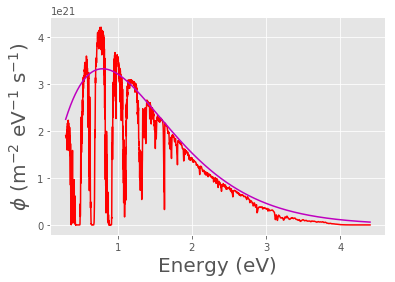

In [9]:
SQ = SQlim()
SQ.plot_AM15flux(temperature=5800, offset=4.8e4)

In [4]:
interactive(SQ.animate_plot, Eg=(0.32, 4.0, 0.01))

interactive(children=(FloatSlider(value=2.16, description='Eg', max=4.0, min=0.32, step=0.01), Output()), _dom…

In [5]:
interactive(SQ.animate_JV, Eg=(0.4, 4.0, 0.01))

interactive(children=(FloatSlider(value=2.2, description='Eg', max=4.0, min=0.4, step=0.01), Output()), _dom_c…